在本次实验中，我们将从之前训练的扩散模型中进行采样。

* 我们将比较 DDPM 和 DDIM 采样器的样本
* 使用条件扩散模型可视化混合样品

In [1]:
from pathlib import Path
from types import SimpleNamespace
import torch
import torch.nn.functional as F
import numpy as np
from utilities import *

import wandb

In [2]:
#登录wb网站
wandb.login(anonymous="allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xiaopan. Use `wandb login --relogin` to force relogin


True

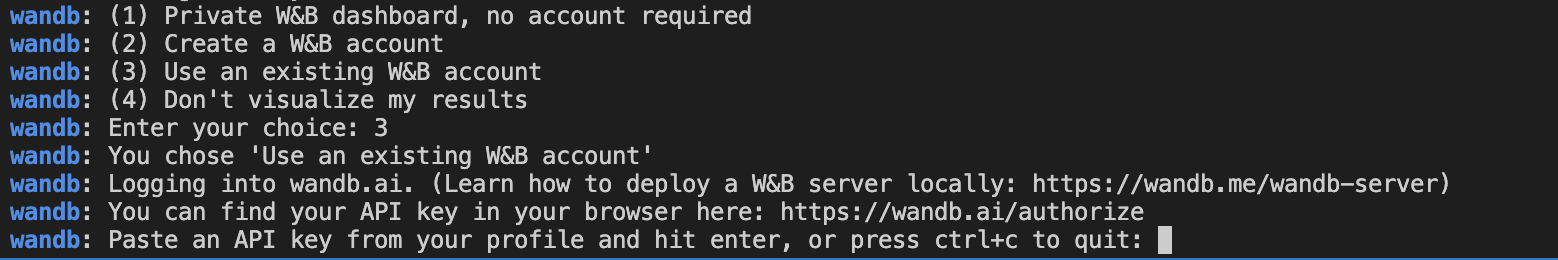
使用wb的账户的api key就可以链接到wb官网

设置 DDPM 噪声调度器和采样器（与扩散课程中的相同）。
* perturb_input：在时间表上相应的时间步长向输入图像添加噪声
* Sample_ddpm_context：使用 DDPM 采样器生成图像，我们将在训练期间使用此函数定期从模型中采样并查看训练进展情况

In [3]:
# Wandb 参数
MODEL_ARTIFACT = "dlai-course/model-registry/SpriteGen:latest"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = SimpleNamespace(
    # 超参数
    num_samples = 30,
    
    # ddpm 采样层参数 
    timesteps = 500,#采样的步长，步长越大，采样时间越长，步长和图片质量没有直接联系
    beta1 = 1e-4,#采样因子
    beta2 = 0.02,#采样因子
    
    # ddim sampler hp
    ddim_n = 25,
    
    # 网络超参数
    height = 16,# 16x16 image
)

在上一个notebook中，我们将最佳模型保存为 wandb Artifact（我们在运行期间存储文件的方式）。 我们现在将从 wandb 加载模型并设置采样循环。

In [4]:
def load_model(model_artifact_name):
    "下载模型"
    api = wandb.Api()
    artifact = api.artifact(model_artifact_name, type="model")
    model_path = Path(artifact.download())

    # 从wb恢复model历史信息
    producer_run = artifact.logged_by()

    # 加载模型训练历史
    model_weights = torch.load(model_path/"context_model.pth", 
                               map_location="cpu")

    # 创建模型
    model = ContextUnet(in_channels=3, 
                        n_feat=producer_run.config["n_feat"], 
                        n_cfeat=producer_run.config["n_cfeat"], 
                        height=producer_run.config["height"])
    
    # 加载模型权重
    model.load_state_dict(model_weights)

    # 评估模型
    model.eval()
    return model.to(DEVICE)

In [5]:
nn_model = load_model(MODEL_ARTIFACT)

wandb:   1 of 1 files downloaded.  


## 采样
我们将采样并将生成的样本记录到 wandb。

In [6]:
#设置 ddpm 采样器功能
_, sample_ddpm_context = setup_ddpm(config.beta1, 
                                    config.beta2, 
                                    config.timesteps, 
                                    DEVICE)

让我们定义一组噪声和一个上下文向量作为条件。

In [7]:
# Noise向量
# x_T ~ N(0, 1), 样本初始噪声
noises = torch.randn(config.num_samples, 3, 
                     config.height, config.height).to(DEVICE)  
# 用于采样的固定上下文向量，不同的样本进行扩散
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing 
                       5).to(DEVICE).float()

In [8]:
#设置 ddpm 采样器功能
sample_ddim_context = setup_ddim(config.beta1, 
                                 config.beta2, 
                                 config.timesteps, 
                                 DEVICE)

## 采样：
让我们像以前一样计算 ddpm 样本

In [9]:
ddpm_samples, _ = sample_ddpm_context(nn_model, noises, ctx_vector)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
#对于 DDIM，我们可以通过 n 参数控制步长
ddim_samples, _ = sample_ddim_context(nn_model, 
                                      noises, 
                                      ctx_vector, 
                                      n=config.ddim_n)

  0%|          | 0/25 [00:00<?, ?it/s]

在表格上可视化
让我们创建一个 wandb.Table 来存储我们的世代

In [11]:
table = wandb.Table(columns=["input_noise", "ddpm", "ddim", "class"])

我们可以将行一一添加到表中，我们还将图像投射到 wandb.Image 中，以便我们可以在 UI 中正确渲染它们

In [12]:
for noise, ddpm_s, ddim_s, c in zip(noises, 
                                    ddpm_samples, 
                                    ddim_samples, 
                                    to_classes(ctx_vector)):
    
    # 逐行添加数据到表中
    table.add_data(wandb.Image(noise),
                   wandb.Image(ddpm_s), 
                   wandb.Image(ddim_s),
                   c)

In [13]:
# 初始化wb
with wandb.init(project="dlai_sprite_diffusion", 
                job_type="samplers_battle", 
                config=config):
    
    wandb.log({"samplers_table":table})

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


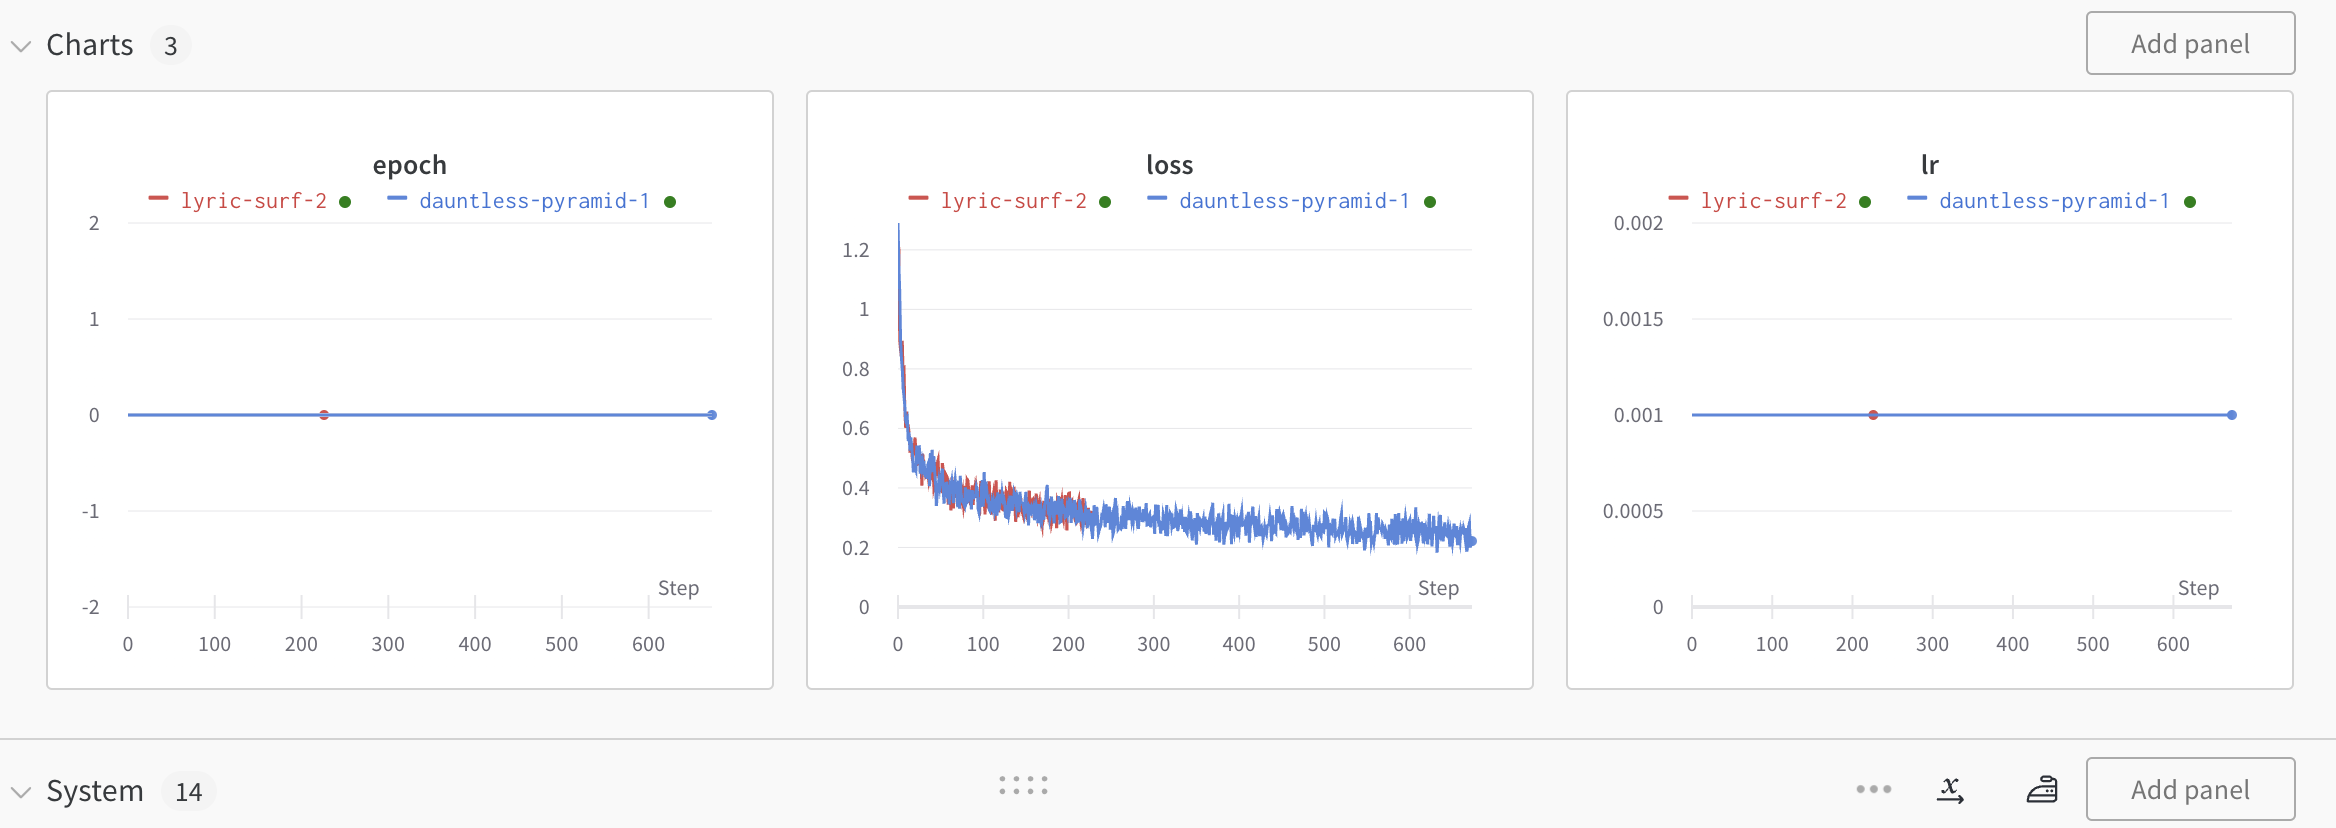
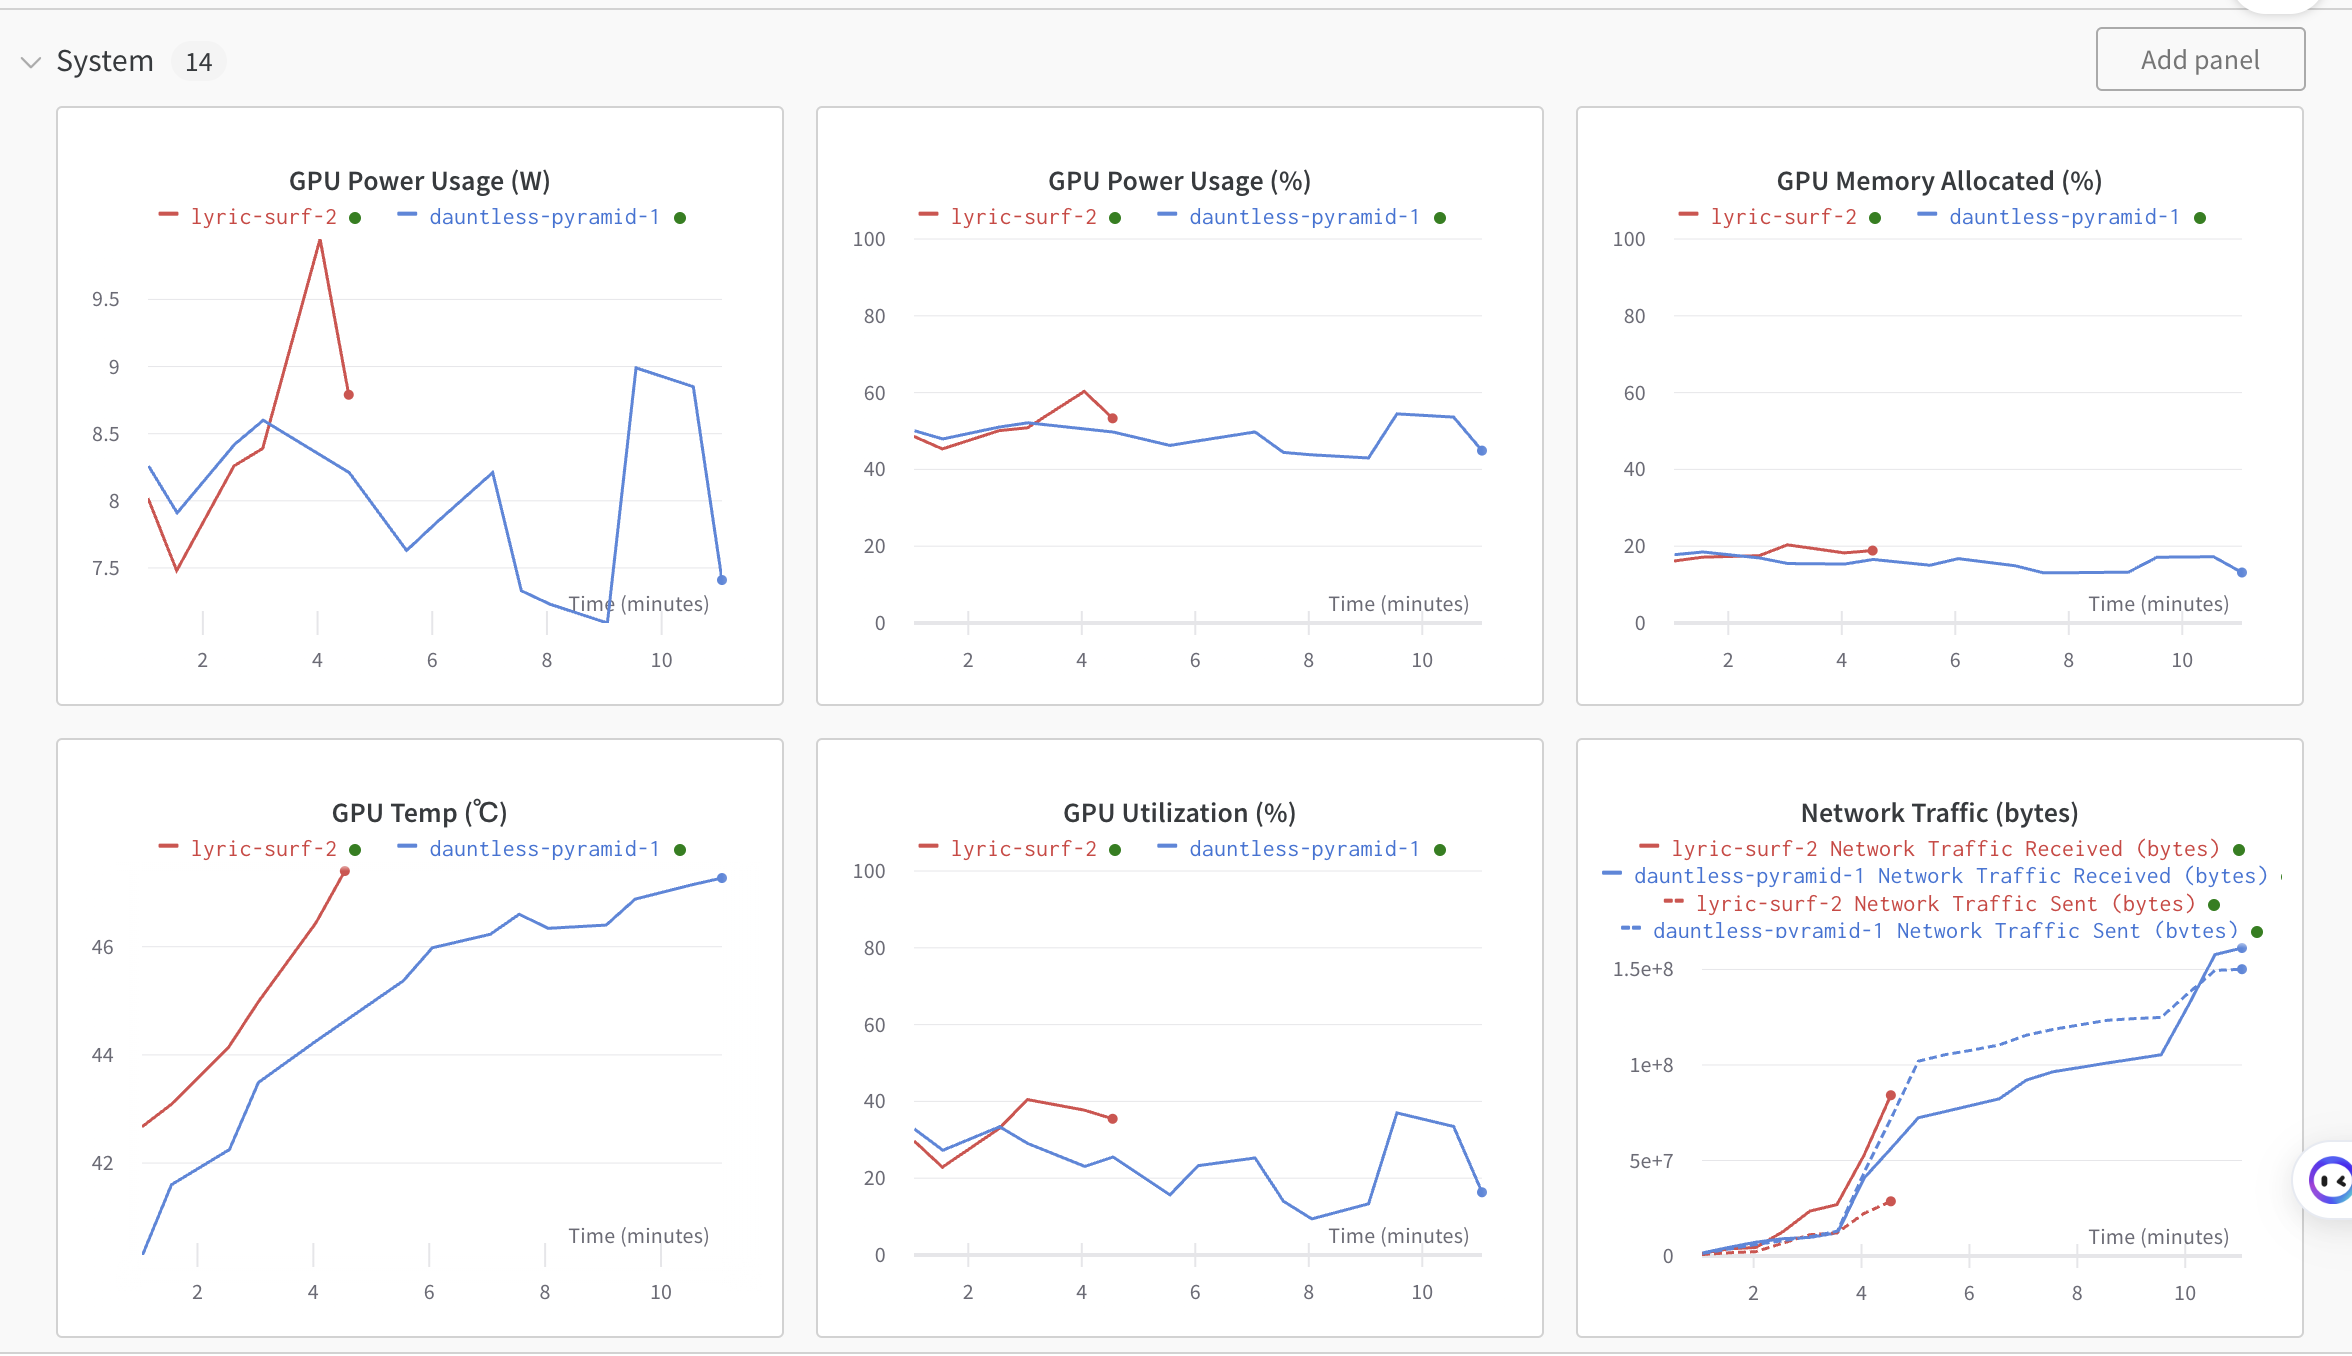
在wb官网就能看到相关的可视化信息
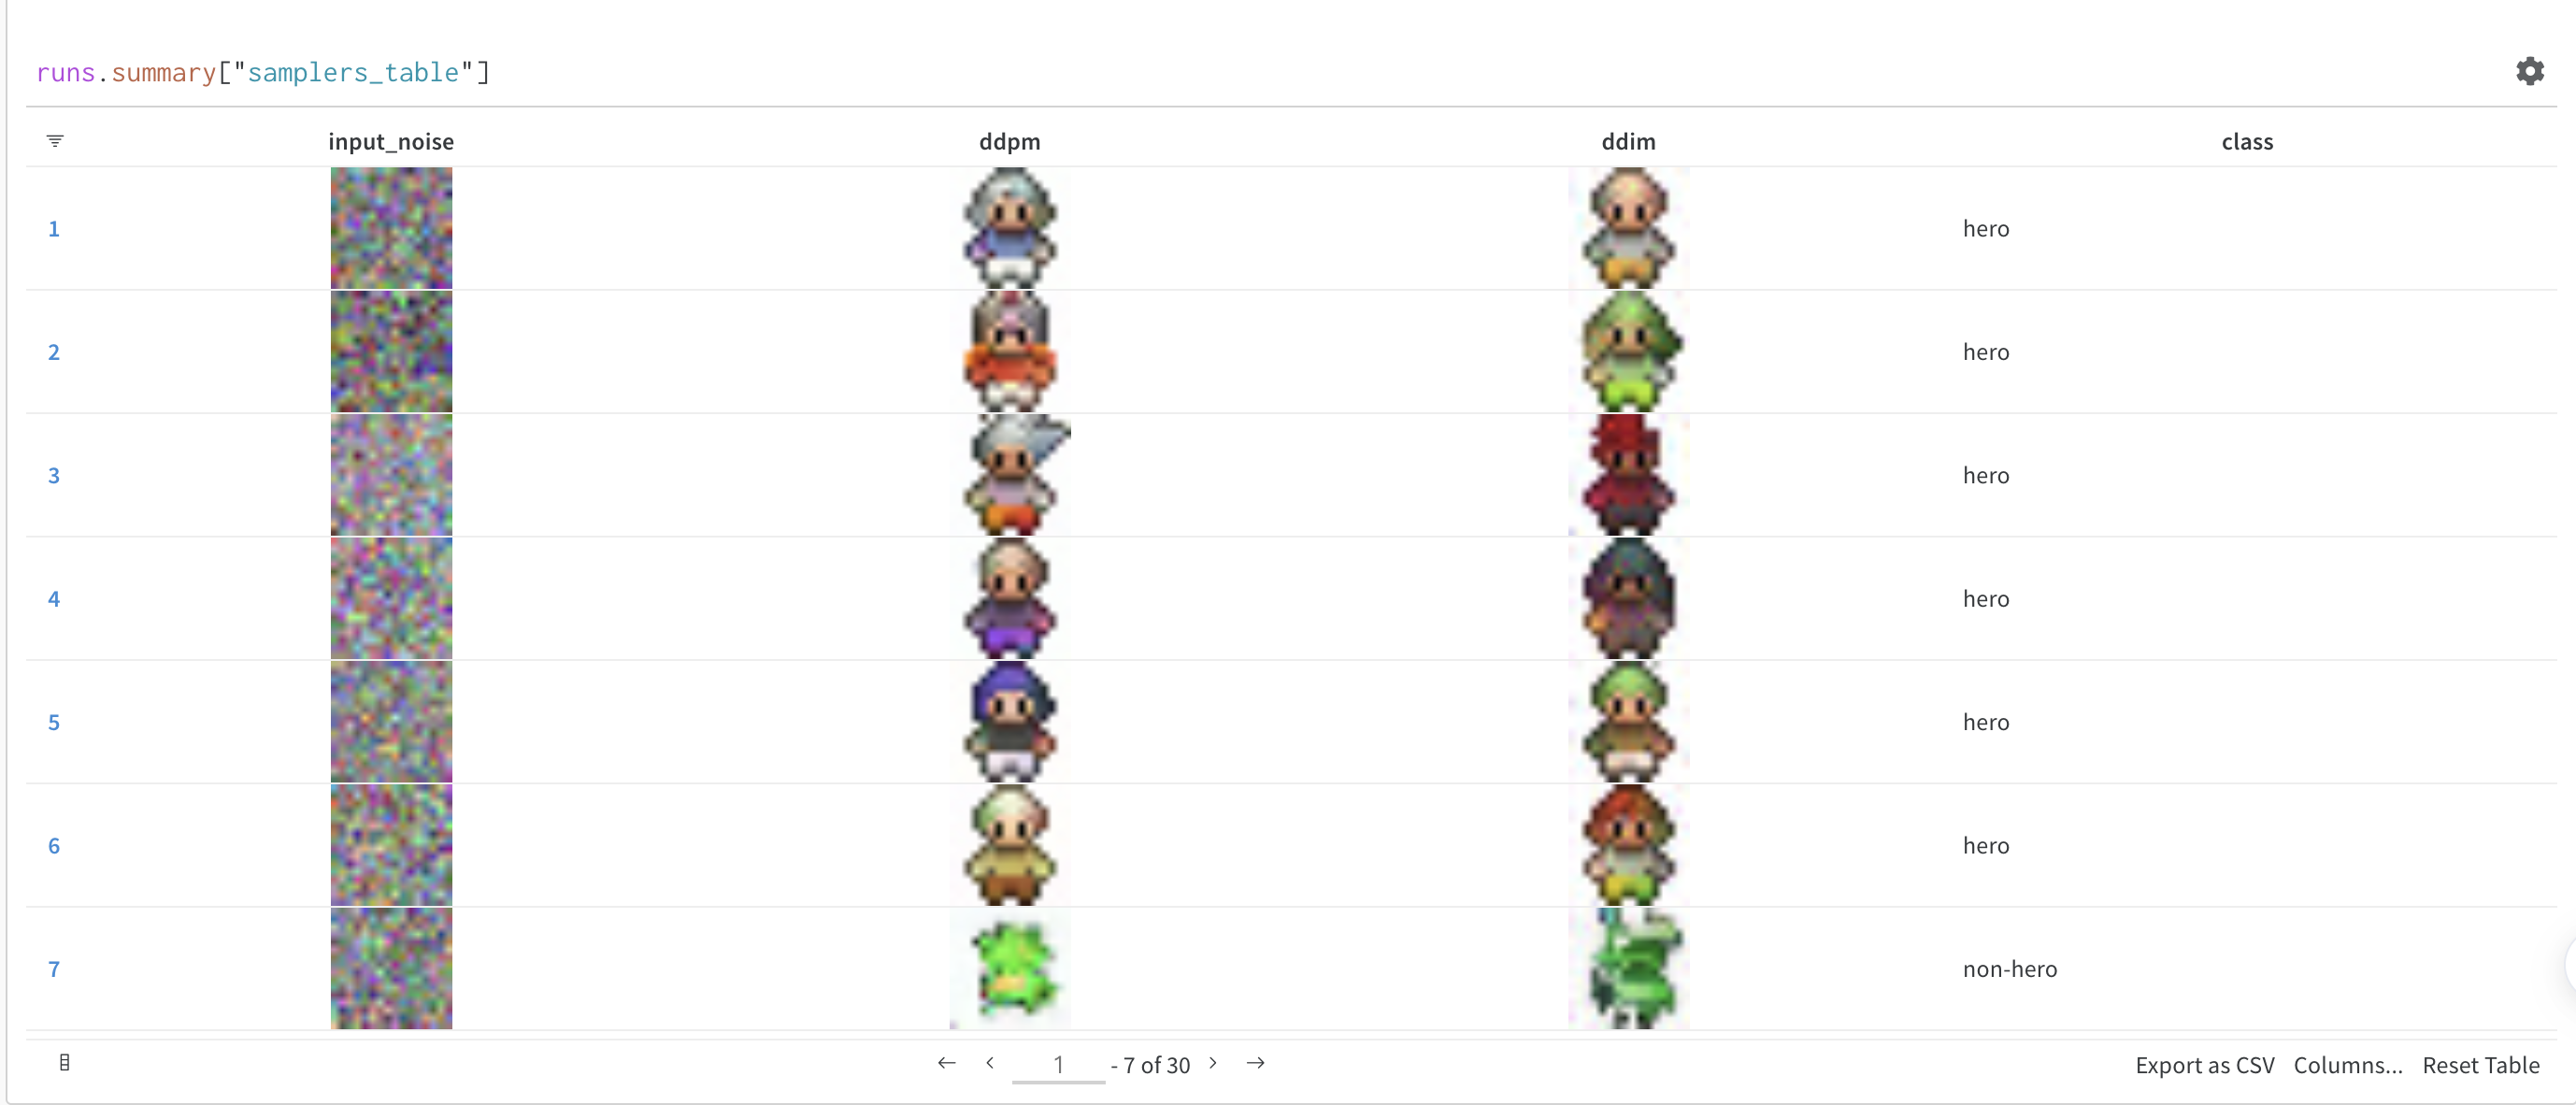
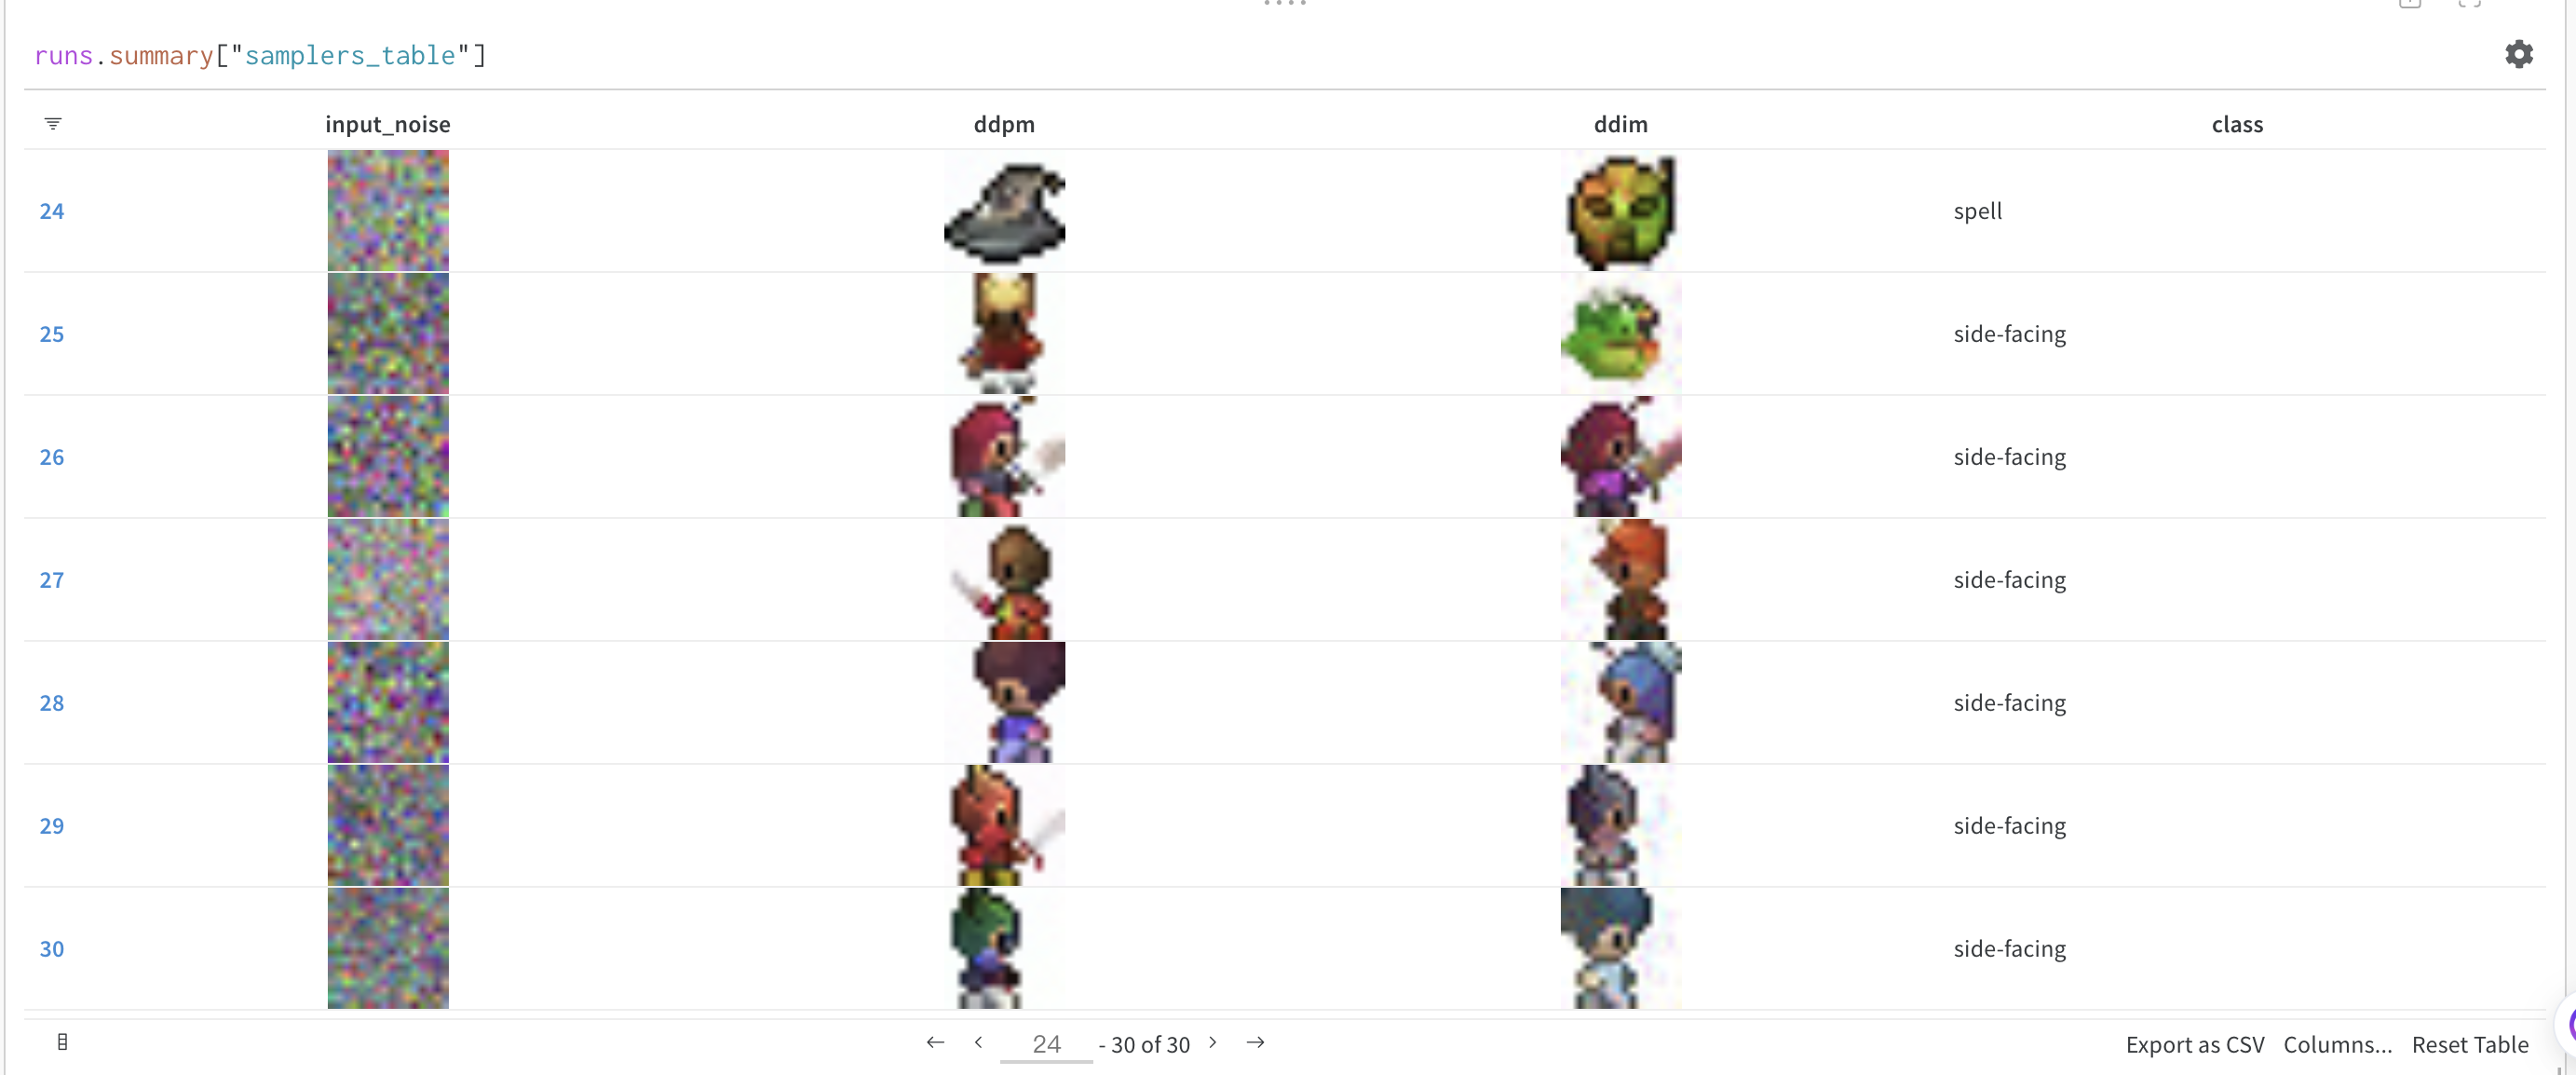
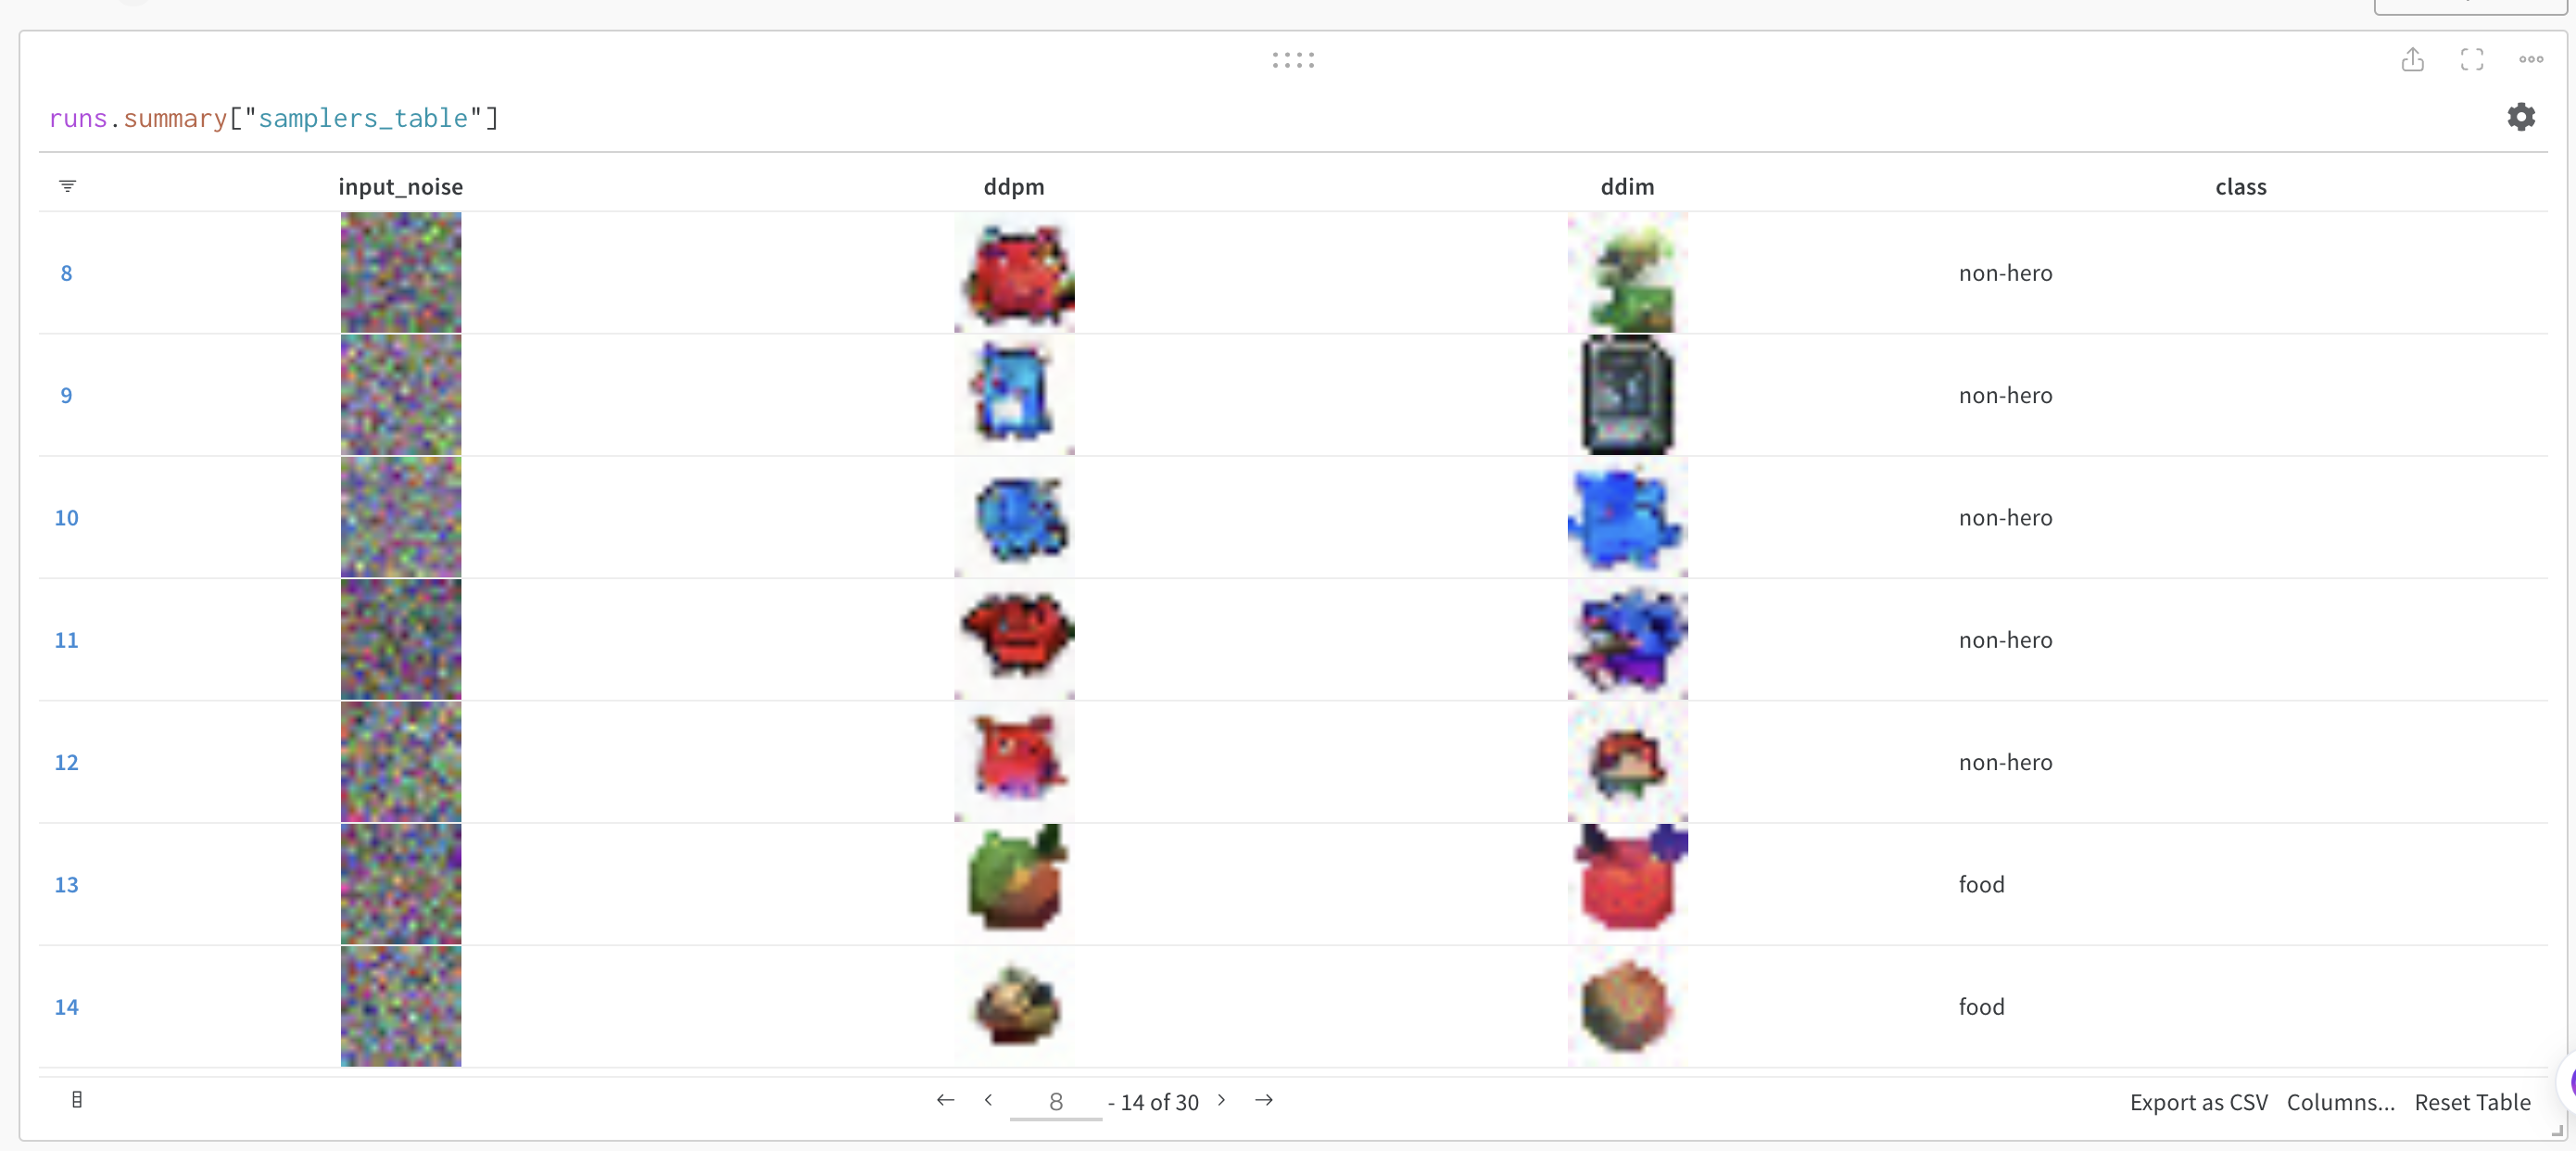
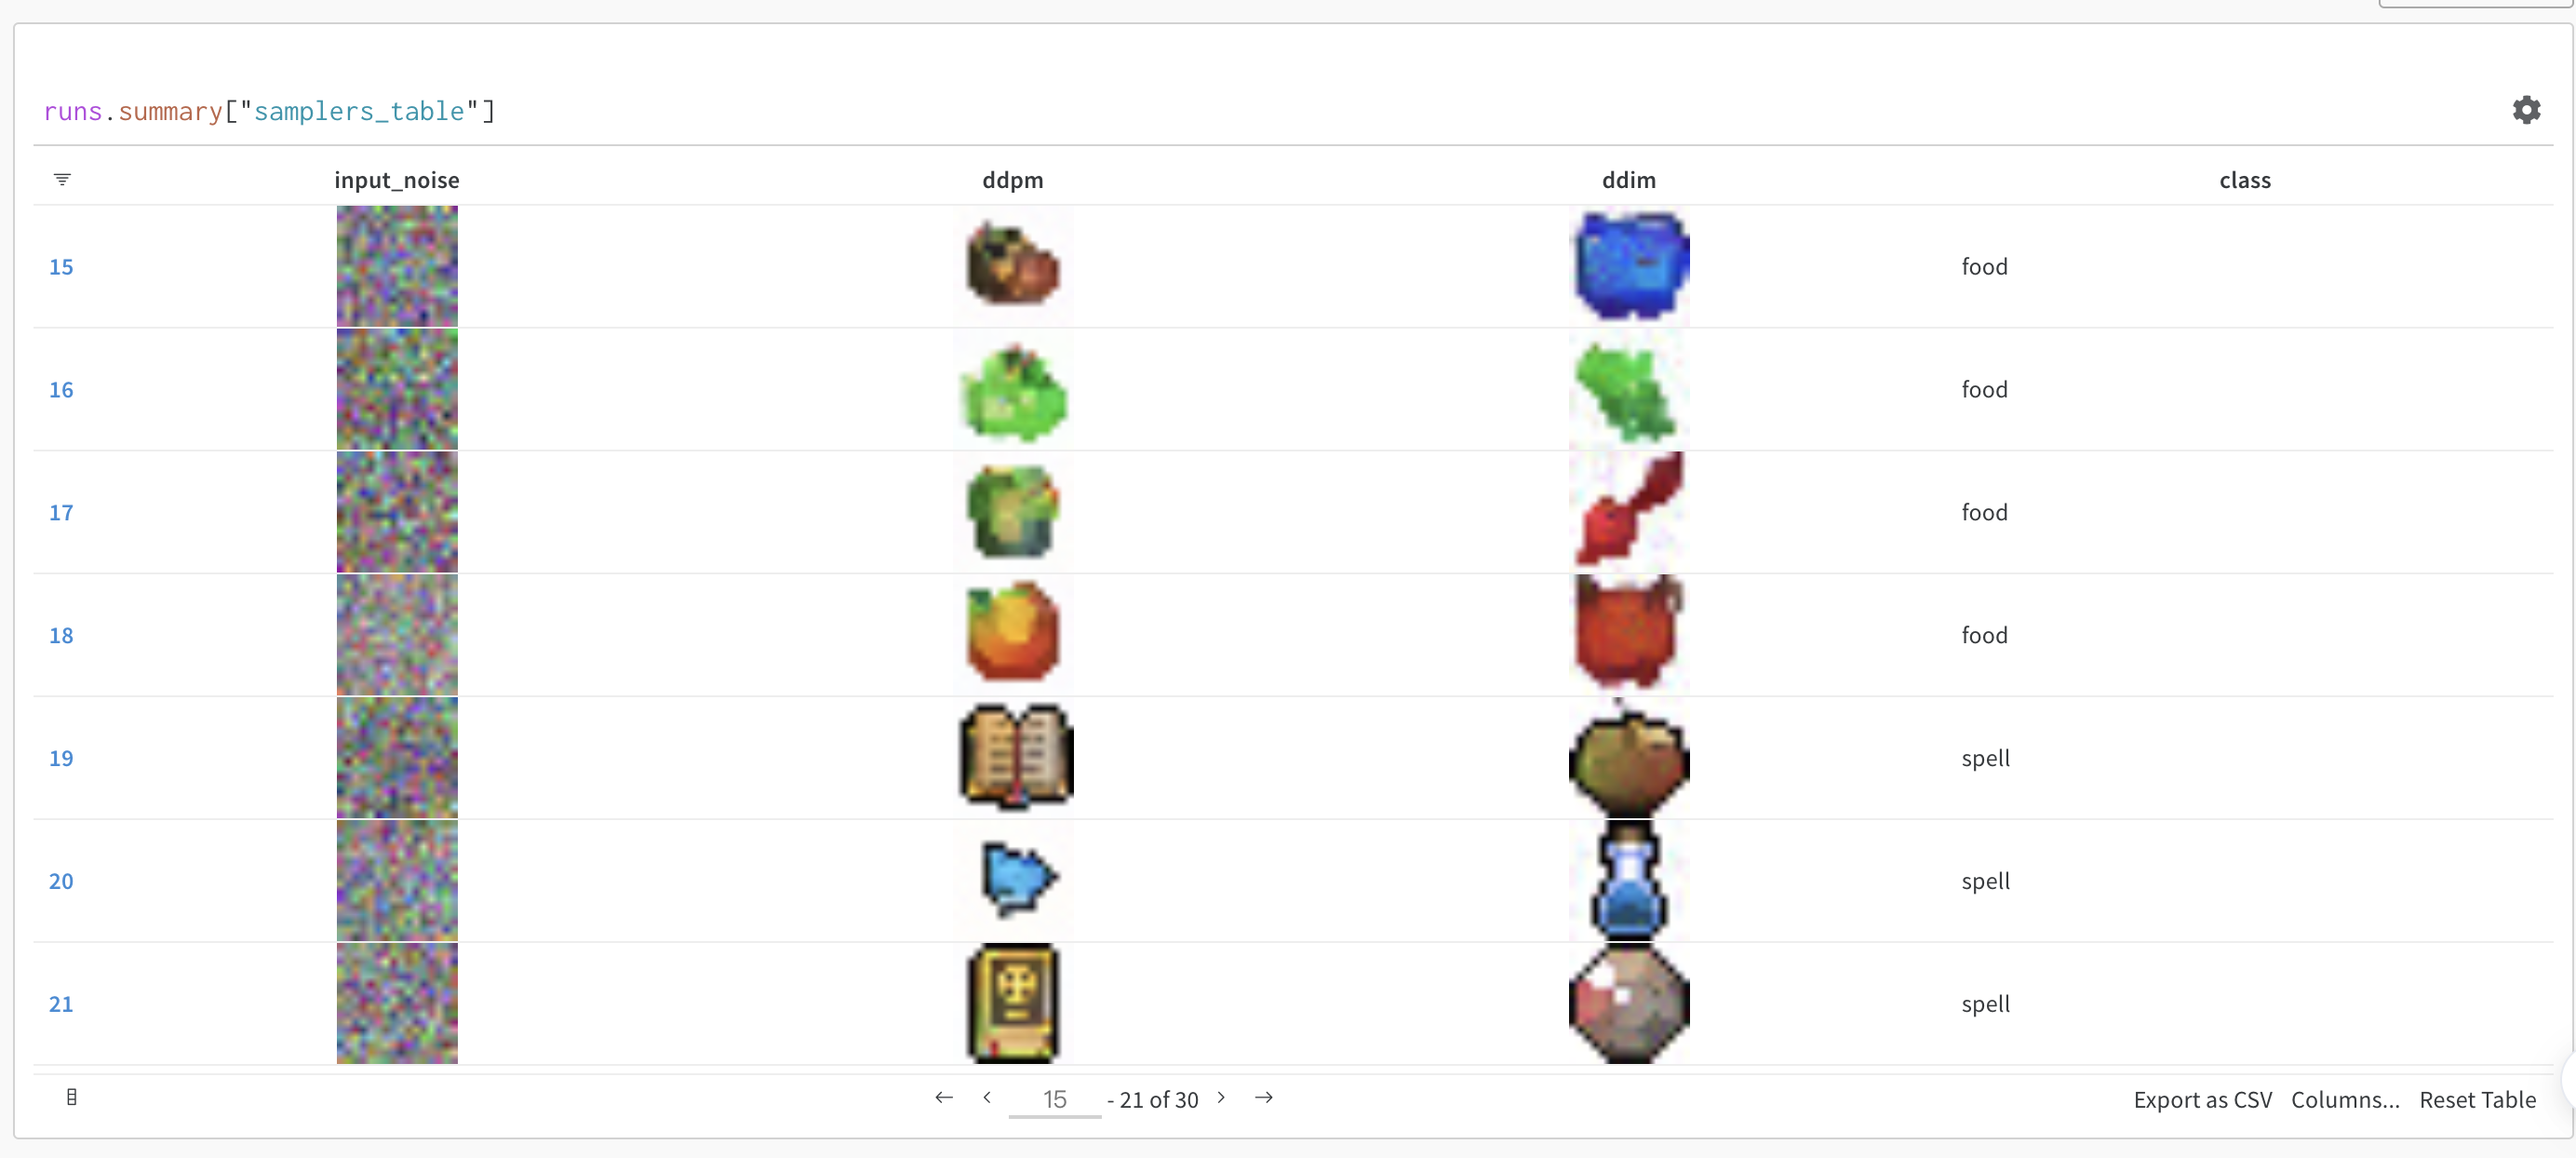

